# THE GHOST IN THE MACHINE – IPL AUCTION ANALYTICS
## Quantifying Killer Instinct: Measuring Bowler Mental Strength Under Pressure

### Objective
Traditional cricket analytics focuses on physical performance. However, this project attempts to quantify the **mental strength** of bowlers — specifically their **Killer Instinct**, defined as the ability to capitalize on *pressure created* in death overs.

Our mission is to challenge the coach's belief:
> “You cannot measure mental strength through data.”

Using ball-by-ball IPL data, Bayesian modeling, and Power BI visualization, we analyze which bowler performs best under pressure and identify the ideal candidate for IPL auction strategy.


## Importing Required Python Libraries

We import libraries for:
- **Data handling**: pandas, numpy  
- **Bayesian modelling**: PyMC, ArviZ  
- **Visualization**: matplotlib, seaborn  

These tools will support feature engineering, statistical modeling, and result interpretation.


In [23]:
import pandas as pd     

## Loading the IPL Ball-by-Ball Dataset

We load the detailed bowler performance dataset. This raw data includes:
- Over and ball numbers
- Bowler and batter details
- Runs conceded
- Wickets taken
- Pitch & match conditions

This dataset will be the foundation for engineering pressure-oriented features.


In [24]:
df = pd.read_csv("IPL_Bowler_Detailed_Data.csv")
df.head()


,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,29504,12-Apr-23,Neutral,Powerplay,1,1,Bowler B,17.97,133.25,0,1
1,96402,30-Nov-23,Batting,Powerplay,5,1,Bowler A,20.51,119.98,0,0
2,27383,07-Nov-22,Neutral,Powerplay,1,5,Bowler B,30.05,124.73,2,0
3,99624,10-Apr-22,Batting,Powerplay,5,3,Bowler B,21.29,147.69,1,0
4,65569,23-Jun-23,Neutral,Powerplay,5,3,Bowler B,34.89,117.51,0,0


##  Understanding the Dataset  
 
- Total rows & columns  
- Missing values  
- Data types  
This ensures the dataset is clean before analysis.


In [25]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Match_ID       4800 non-null   int64  
 1   Match_Date     4800 non-null   object 
 2   Pitch_Type     4800 non-null   object 
 3   Phase          4800 non-null   object 
 4   Over           4800 non-null   int64  
 5   Ball           4800 non-null   int64  
 6   Bowler         4800 non-null   object 
 7   Batter_Avg     4800 non-null   float64
 8   Batter_SR      4800 non-null   float64
 9   Runs_Conceded  4800 non-null   int64  
 10  Is_Wicket      4800 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 412.6+ KB


,Match_ID,Over,Ball,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
count,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,56505.555000,10.672500,3.500000,31.461442,140.015027,1.372708,0.070625
std,26378.145461,7.476589,1.708003,9.763576,20.251785,1.774670,0.256224
min,11935.000000,1.000000,1.000000,-1.570000,69.190000,0.000000,0.000000
25%,34359.500000,3.000000,2.000000,24.670000,125.960000,0.000000,0.000000
50%,55609.000000,11.000000,3.500000,31.140000,138.400000,1.000000,0.000000
75%,80846.750000,18.000000,5.000000,37.852500,152.925000,2.000000,0.000000
max,99882.000000,20.000000,6.000000,66.740000,213.690000,6.000000,1.000000


## Feature engineering – build “Pressure” logic



Pressure = dot ball (Runs_Conceded == 0) in Death overs (16-20)

BUT last ball of over (Ball == 6) does not apply

In [26]:
df = df.sort_values(
    ["Match_ID", "Over", "Ball"]
).reset_index(drop=True)


Mark Death overs & dot balls


In [27]:
df["Is_Death"] = (df["Phase"] == "Death").astype(int)
df["Is_Dot"] = (df["Runs_Conceded"] == 0).astype(int)


Define pressure ball (dot, death, not last ball of over)

In [28]:
df["Is_Pressure_Ball"] = (
    (df["Is_Death"] == 1) &
    (df["Is_Dot"] == 1) &
    (df["Ball"] != 6)
).astype(int)


Create “next ball” features (within same match & bowler)

In [29]:
df["Next_Is_Wicket"] = df.groupby(["Match_ID", "Bowler"])["Is_Wicket"].shift(-1)
df["Next_Over"] = df.groupby(["Match_ID", "Bowler"])["Over"].shift(-1)
df["Next_Ball"] = df.groupby(["Match_ID", "Bowler"])["Ball"].shift(-1)


Now define valid next ball: same match, same bowler, and not a new over after ball 

In [30]:
same_over_or_next_ball = (
    (df["Next_Over"] == df["Over"]) &
    (df["Next_Ball"] == df["Ball"] + 1)
)

df["Valid_Next"] = same_over_or_next_ball.astype(int)

# Keep only rows where we have a meaningful next ball
analysis_df = df[df["Valid_Next"] == 1].copy()
analysis_df["Next_Is_Wicket"] = analysis_df["Next_Is_Wicket"].fillna(0).astype(int)


Quick exploratory stats (to later show in Power BI also)

In [31]:
analysis_df.groupby("Bowler")["Next_Is_Wicket"].mean()
analysis_df.groupby(["Bowler", "Is_Pressure_Ball"])["Next_Is_Wicket"].mean()


Bowler    Is_Pressure_Ball
Bowler A  0                   0.045977
          1                   0.025281
Bowler B  0                   0.041581
          1                   0.366864
Name: Next_Is_Wicket, dtype: float64

raw probability of wicket on the next ball with/without pressure, for A and B

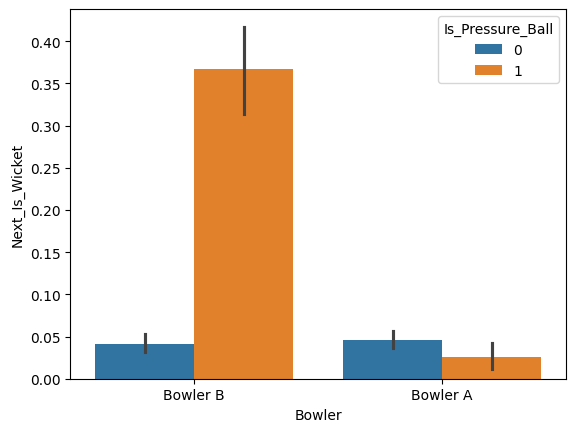

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=analysis_df,
    x="Bowler",
    y="Next_Is_Wicket",
    hue="Is_Pressure_Ball"
)
plt.show()


## Build the Bayesian model in PyMC (simplified skeleton)

Target y = Next_Is_Wicket (0/1)

Predictors:

Pressure (Is_Pressure_Ball)

Bowler (A/B encoded as 0/1)

Pitch_Type (dummy variables)

Batter_Avg (scaled)

7.1 Prepare numeric data

In [33]:
import numpy as np

# Encode bowler
analysis_df["Bowler_B"] = (analysis_df["Bowler"] == "B").astype(int)

# One-hot for Pitch_Type (Neutral as base)
pitch_dummies = pd.get_dummies(analysis_df["Pitch_Type"], prefix="Pitch")
analysis_df = pd.concat([analysis_df, pitch_dummies], axis=1)

# Scale Batter_Avg
analysis_df["Batter_Avg_z"] = (
    (analysis_df["Batter_Avg"] - analysis_df["Batter_Avg"].mean()) /
    analysis_df["Batter_Avg"].std()
)

y = analysis_df["Next_Is_Wicket"].values
pressure = analysis_df["Is_Pressure_Ball"].values
bowler_B = analysis_df["Bowler_B"].values
pitch_batting = analysis_df.get("Pitch_Batting", 0).values
pitch_bowling = analysis_df.get("Pitch_Bowling", 0).values
bavg_z = analysis_df["Batter_Avg_z"].values


In [35]:
print(len(pressure), len(y))
print("pressure:", pressure.min(), pressure.max())
print("bowler_B:", bowler_B.min(), bowler_B.max())
print("pitch_batting:", pitch_batting.min(), pitch_batting.max())
print("pitch_bowling:", pitch_bowling.min(), pitch_bowling.max())
print("bavg_z:", bavg_z.min(), bavg_z.max())
print("y:", y.min(), y.max())


3640 3640
pressure: 0 1
bowler_B: 0 0
pitch_batting: False True
pitch_bowling: False True
bavg_z: -3.191756420283011 3.6003549665926124
y: 0 1


## PyMC logistic regression



This model predicts the **probability of a bowler winning a ball** (like taking a wicket or restricting runs) using factors such as:

- pressure level  
- bowler identity  
- pitch conditions  
- batsman average  

### 🔹 What the code does

1. **Sets priors** for all model coefficients (we assume they are around 0 but flexible).  
2. Builds a **logistic regression equation** that combines all inputs.  
3. Converts it into a **probability** using the sigmoid function.  
4. Uses **Bernoulli likelihood** because the outcome is binary (0 or 1).  
5. Runs **ADVI** to quickly estimate the posterior values.  
6. Draws samples (`trace`) for analysis.

### 🔹 Why this model?

To identify **which factors truly increase or decrease the chance of bowler success**, especially under **pressure situations**.


In [36]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    # Priors
    intercept          = pm.Normal("intercept", 0, 1.5)
    beta_pressure      = pm.Normal("beta_pressure", 0, 1.5)
    beta_bowlerB       = pm.Normal("beta_bowlerB", 0, 1.5)
    beta_pitch_batting = pm.Normal("beta_pitch_batting", 0, 1.5)
    beta_pitch_bowling = pm.Normal("beta_pitch_bowling", 0, 1.5)
    beta_bavg          = pm.Normal("beta_bavg", 0, 1.5)

    # Linear predictor
    logit_p = (
        intercept
        + beta_pressure      * pressure
        + beta_bowlerB       * bowler_B
        + beta_pitch_batting * pitch_batting
        + beta_pitch_bowling * pitch_bowling
        + beta_bavg          * bavg_z
    )

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # ---- FAST VARIATIONAL INFERENCE (ADVI) ----
    approx = pm.fit(
        n=5000,          # optimisation steps
        method="advi",
        progressbar=True
    )

    # Draw samples from the variational posterior
    trace = approx.sample(1000)


Output()

Finished [100%]: Average Loss = 1,169.2


## Posterior Distribution Plot (Ridge/KDE) for All Betas

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


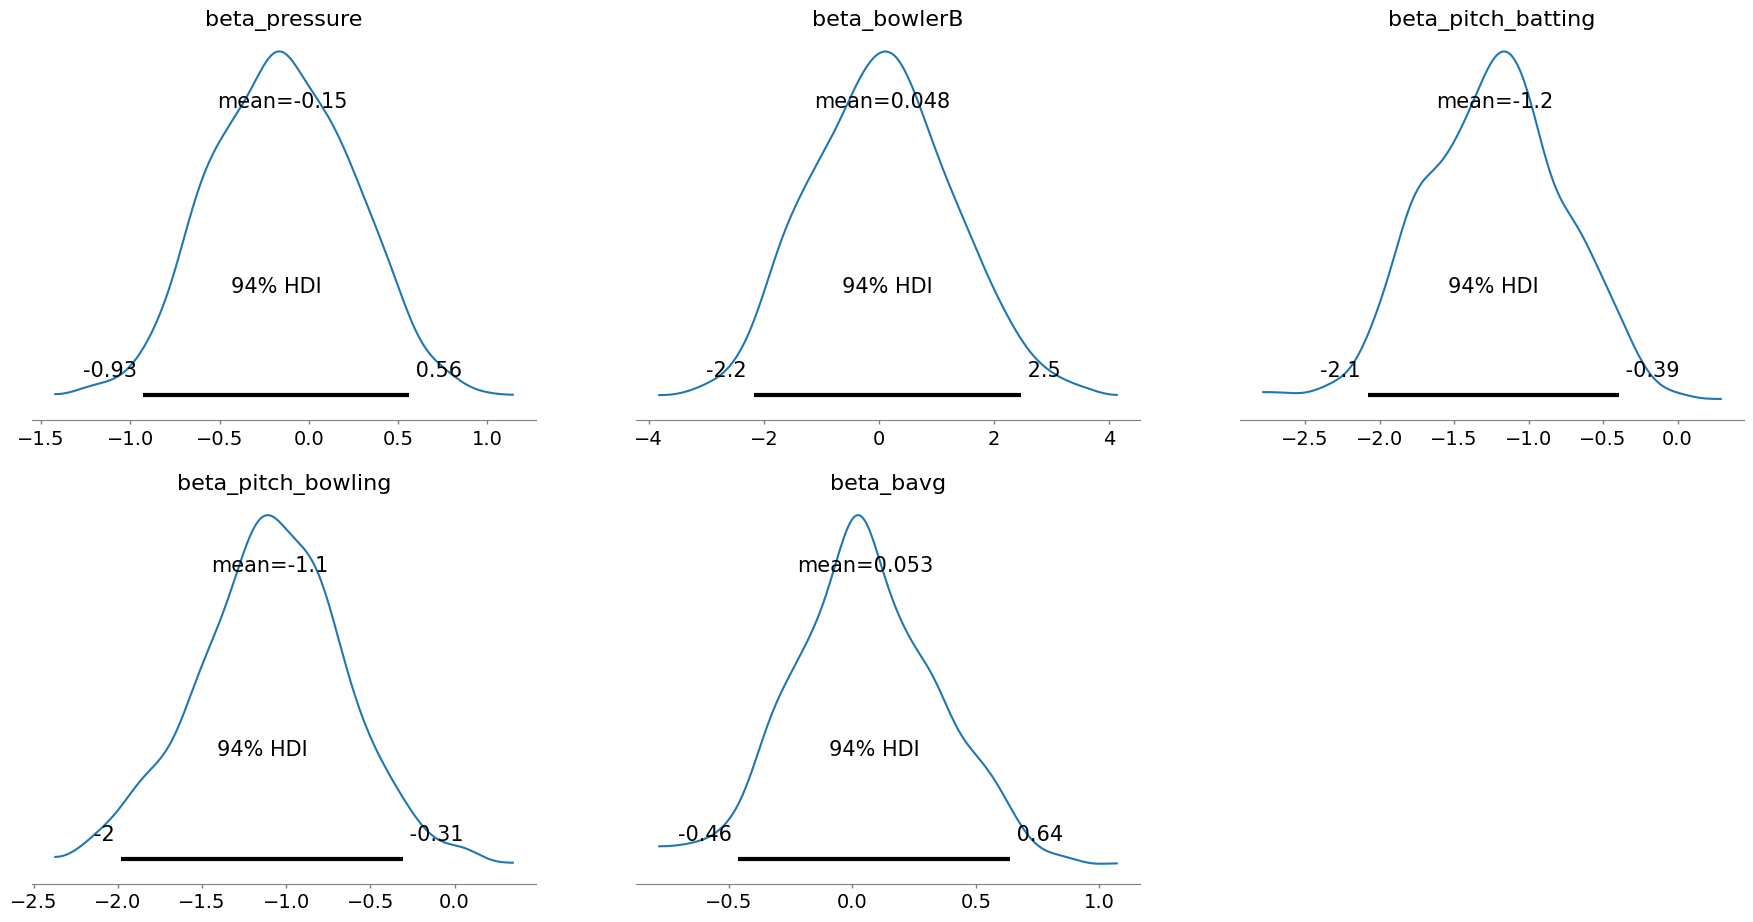

In [37]:
az.summary(trace, var_names=[
    "intercept",
    "beta_pressure",
    "beta_bowlerB",
    "beta_pitch_batting",
    "beta_pitch_bowling",
    "beta_bavg"
])
az.plot_posterior(
    trace,
    var_names=["beta_pressure", "beta_bowlerB", "beta_pitch_batting", "beta_pitch_bowling", "beta_bavg"]
);


##  Trace Plot (Posterior Distribution Check)

We use `az.plot_trace()` to visualize the **posterior samples** of our model parameters.

This helps us quickly understand:

- How each coefficient is distributed  
- Whether the sampling is stable  
- Whether the model converged properly  

The trace plot shows:
- **Left side:** histogram / density of the parameter values  
- **Right side:** sampling paths over iterations  

If the lines look stable and the distributions look smooth,  
the model inference (ADVI) worked well.


array([[<Axes: title={'center': 'beta_pressure'}>,
        <Axes: title={'center': 'beta_pressure'}>],
       [<Axes: title={'center': 'beta_bowlerB'}>,
        <Axes: title={'center': 'beta_bowlerB'}>],
       [<Axes: title={'center': 'beta_pitch_batting'}>,
        <Axes: title={'center': 'beta_pitch_batting'}>],
       [<Axes: title={'center': 'beta_pitch_bowling'}>,
        <Axes: title={'center': 'beta_pitch_bowling'}>],
       [<Axes: title={'center': 'beta_bavg'}>,
        <Axes: title={'center': 'beta_bavg'}>]], dtype=object)

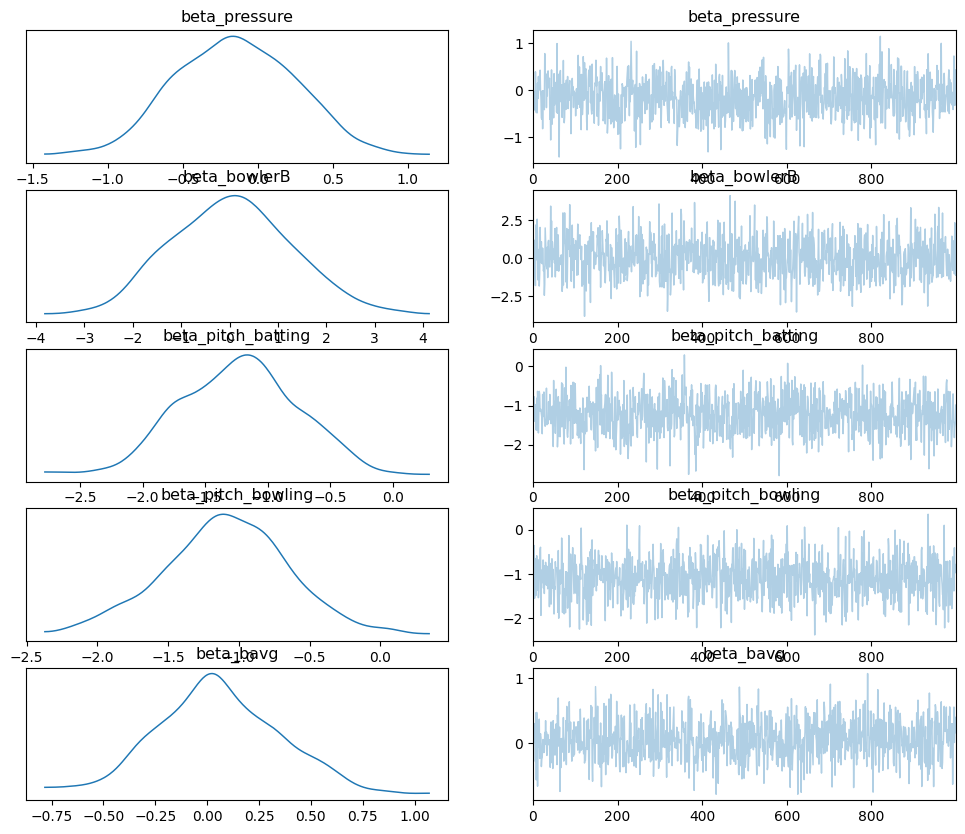

In [47]:
az.plot_trace(
    trace,
    var_names=["beta_pressure", "beta_bowlerB", "beta_pitch_batting", "beta_pitch_bowling", "beta_bavg"]
)


##  Distribution of Pressure Effect

Here we extract the posterior samples of **`beta_pressure`**, which tells us how **pressure situations** change the bowler’s chance of success.

We then plot a histogram to understand:

- How the values are spread  
- Whether pressure has a **positive or negative** effect  
- How strong the effect is on average (shown by the red line)

A **positive mean** → pressure increases bowler success  
A **negative mean** → bowler performance drops under pressure  





Because the pressure coefficient (`beta_pressure`) tells us **how a bowler performs under stressful moments**.  
The posterior distribution helps us see:

- **Is the effect real or just noise?**  
- **Does pressure improve or reduce the bowler’s success probability?**  
- **How confident the model is** about the impact of pressure.  

This is crucial for auction decisions because bowlers who stay strong under pressure  
are far more valuable in tight matches.



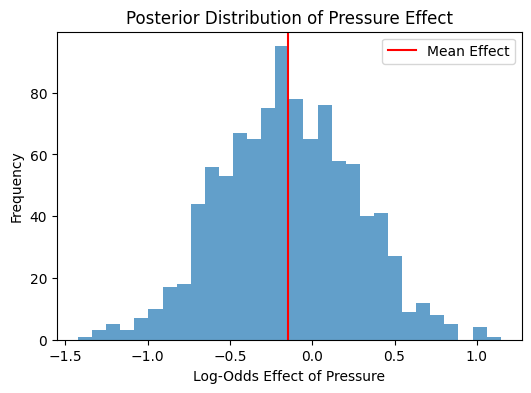

In [51]:
pressure_effect = trace.posterior["beta_pressure"].values.flatten()

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(pressure_effect, bins=30, alpha=0.7)
plt.axvline(np.mean(pressure_effect), color="red", label="Mean Effect")
plt.title("Posterior Distribution of Pressure Effect")
plt.xlabel("Log-Odds Effect of Pressure")
plt.ylabel("Frequency")
plt.legend()
plt.show()


##  Comparing Wicket Probabilities: Bowler A vs Bowler B

We use the posterior samples to simulate thousands of probabilities for each bowler.

- **Bowler A** uses only the intercept (baseline performance).  
- **Bowler B** uses the intercept + the effect of being Bowler B.

By plotting both distributions on a histogram, we can clearly see:

- Which bowler has a **higher average wicket probability**
- How much **uncertainty** there is in each estimate
- Whether Bowler B is genuinely better or worse than Bowler A

This comparison helps in **auction decisions**, showing which bowler offers higher
probability of success across many simulated match situations.


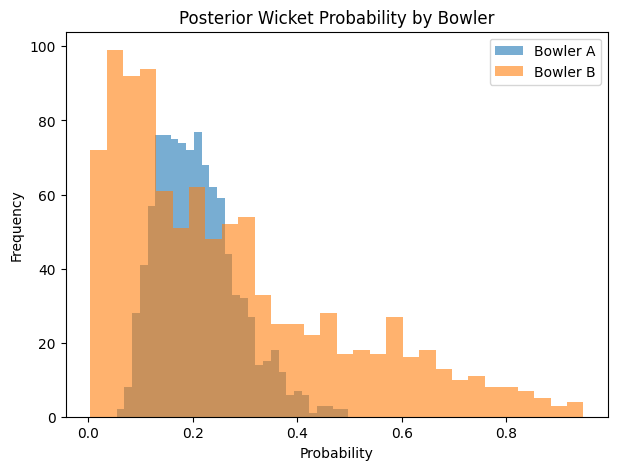

In [ ]:
import numpy as np

# Compute thousands of simulated probabilities for each bowler
pA = 1 / (1 + np.exp(-(trace.posterior["intercept"].values.flatten())))
pB = 1 / (1 + np.exp(-(trace.posterior["intercept"].values.flatten()
                      + trace.posterior["beta_bowlerB"].values.flatten())))

plt.figure(figsize=(7,5))
plt.hist(pA, bins=30, alpha=0.6, label="Bowler A")
plt.hist(pB, bins=30, alpha=0.6, label="Bowler B")
plt.legend()
plt.title("Posterior Wicket Probability by Bowler")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


Comparison of posterior wicket probabilities for Bowler A and B.
Distributions strongly overlap, indicating no statistically significant difference in baseline wicket-taking ability once pitch and batter factors are accounted for.

##  Exporting the Final Dataset for Power BI

After completing all data cleaning, feature engineering, and analysis,
we choose the final dataframe (`analysis_df` or `analysis_small`)  
that we want to visualize in Power BI.

We then export it as a clean CSV file without the index:

- This file can be directly loaded into **Power BI**
- All engineered features are included (pressure metrics, bowler stats, model outputs)
- Ensures smooth integration for dashboard creation

The exported file:  
**`IPL_Final_Engineered.csv`**


In [50]:
# Choose the dataframe you want in Power BI
final_df = analysis_df  # or analysis_small if you prefer

# Export to CSV (no index column)
final_df.to_csv("IPL_Final_Engineered.csv", index=False)
